# Word2Vec from scratch

Cuando no contamos con datos etiquetados para trabajar con lenguaje natural nos vemos obligados a analizar la información en profundidad para extraer todos los insights posibles. La ventaja del lenguaje natural consiste en la riqueza de estos patrones implícitos cuando se expresa en embeddings.

Construiremos una arquitectura Word2Vec (con el algoritmo CBOW) y la entrenaremos sobre un texto de dataset de reviews.
* Generaremos una representación vectorizada de cada review y las plotearemos en un scatterplot con reducción de la dimensionalidad para ver cómo se separan. 
* Extraeremos los embeddings de algunas palabras y analizaremos las distancias con otras.

**Recursos:**
* Paper de Word2Vec: https://arxiv.org/abs/1301.3781
* Explicación de Word2Vec: https://jalammar.github.io/illustrated-word2vec/

### Introducción
#### Embedding
Un *embedding* es una representación o descripcion numerica de un dato, como ejemplo son el mapeo de imagenes o palabras a numeros.

Word2vec es una técnica para el procesamiento de lenguaje natural para producir word embeddings. El algoritmo Word2vec utiliza un modelo de red neuronal para aprender asociaciones de palabras a partir de un gran corpus de texto y produce un espacio vectorial. Los word embeddings están colocados en el espacio vectorial de forma que las palabras que comparten contextos comunes en el corpus están localizadas cerca unas de otras en el espacio.

Si los embeddings son la representacion numerica de las palabras, quiere decir que podriamos realizar operaciones entre ellas para compararlas u obtener nuevos resultados.

#### *CBOW Model:* Continuous Bag of Words Model

Este algoritmo utiliza como entrada el contexto de la palabra objetivo (palabras a la izquierda y a la derecha de ella), para ello se define un tamaño de ventana que establece cuantas palabras se tomarán para contextualizar el embedding.

Para entrenar necesitasmos tener el vocabulario del corpus y las sentencias organizadas por el tamaño de la ventana de entrada.

Los embeddings de cada palabra son el embedding promedio de todas las veces que se utilizó en el corpus.

#### Hyperparametros
Hay dos hyperparametros claves en el entrenamiento del Word2Vec, uno es el tamaño de la ventana que define el contexto y el segundo es el numero de muestras negativas.


Segun nuestra aplicacion definiremos el tamaño de la ventana. Por un lado, una ventana pequeña (entre 2 y 15 palabras) conduciran a un embedding en el que palabras con similares puntuaciones podran ser intercambiables (hay que tener cuidado ya que no significa que dos palabras sean sinonimos, ya que dos antonimos pueden ser intercambiables aunque cambien el significado de la horacion, como por ejemplo, bueno y malo pueden aparecer en el mismo contexto).

Ventanas de mayor dimension (entre 15 y 50 palabras) conducen a embeddings donde puntuaciones similares son mas indicativas de la relacion entre las palabras.

El numero de muestra negativas es otro factor de importancia en el proceso de entrenamiento. El paper original recomienda entre 5 y 20 como un buen numero de muestras negativas. Tambien establece que entre 2 y 5 es suficiente cuando se tiene un conjunto de datos suficientemente grande.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv
import os

### Analisis del dataset

In [ ]:
os.listdir()

['.config', 'reviews.csv', 'sample_data']

In [ ]:
df = pd.read_csv('1-Reviews_Word2Vec_from_Scratch.csv')
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOEhZuqSqqWnaKRgv-9ABYdajFUB0WugPGh-SG-...,Eric Tie,https://play-lh.googleusercontent.com/a-/AOh14...,I cannot open the app anymore,1,0,5.4.0.6,2020-10-27 21:24:41,NaN,NaN,newest,com.anydo
1,gp:AOqpTOH0WP4IQKBZ2LrdNmFy_YmpPCVrV3diEU9KGm3...,john alpha,https://play-lh.googleusercontent.com/a-/AOh14...,I have been begging for a refund from this app...,1,0,NaN,2020-10-27 14:03:28,"Please note that from checking our records, yo...",2020-10-27 15:05:52,newest,com.anydo
2,gp:AOqpTOEMCkJB8Iq1p-r9dPwnSYadA5BkPWTf32Z1azu...,Sudhakar .S,https://play-lh.googleusercontent.com/a-/AOh14...,Very costly for the premium version (approx In...,1,0,NaN,2020-10-27 08:18:40,NaN,NaN,newest,com.anydo
3,gp:AOqpTOGFrUWuKGycpje8kszj3uwHN6tU_fd4gLVFy9z...,SKGflorida@bellsouth.net DAVID S,https://play-lh.googleusercontent.com/-75aK0WF...,"Used to keep me organized, but all the 2020 UP...",1,0,NaN,2020-10-26 13:28:07,What do you find troublesome about the update?...,2020-10-26 14:58:29,newest,com.anydo
4,gp:AOqpTOHls7DW8wmDFzTkHwxuqFkdNQtKHmO6Pt9jhZE...,Louann Stoker,https://play-lh.googleusercontent.com/-pBcY_Z-...,Dan Birthday Oct 28,1,0,5.6.0.7,2020-10-26 06:10:50,NaN,NaN,newest,com.anydo


In [ ]:
print('Valores NULL en el dataset:')
df.isnull().sum()

Valores NULL en el dataset:


reviewId                   0
userName                   0
userImage                  0
content                    0
score                      0
thumbsUpCount              0
reviewCreatedVersion    2162
at                         0
replyContent            6677
repliedAt               6677
sortOrder                  0
appId                      0
dtype: int64

In [ ]:
df.drop(columns=['reviewId','userName','userImage','score','thumbsUpCount','reviewCreatedVersion','at','replyContent','repliedAt','sortOrder','appId'],axis=1, inplace = True)

In [ ]:
df.head()

,content
0,I cannot open the app anymore
1,I have been begging for a refund from this app...
2,Very costly for the premium version (approx In...
3,"Used to keep me organized, but all the 2020 UP..."
4,Dan Birthday Oct 28


In [ ]:
print("Cantidad de reviews:", df.shape[0])

Cantidad de reviews: 12495


### Preprocesamiento:

En las siguientes lineas de codigo se recorren todas las filas y se transforman las oraciones en secuencia de palabras.

In [ ]:
from keras.preprocessing.text import text_to_word_sequence

sentence_tokens = []
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [ ]:
sentence_tokens[:2] #secuencia de palabras

[['i', 'cannot', 'open', 'the', 'app', 'anymore'],
 ['i',
  'have',
  'been',
  'begging',
  'for',
  'a',
  'refund',
  'from',
  'this',
  'app',
  'for',
  'over',
  'a',
  'month',
  'and',
  'nobody',
  'is',
  'replying',
  'me']]

### Creacion de vectores WORD2VEC



In [ ]:
import multiprocessing
from gensim.models import Word2Vec

In [ ]:
# Crearmos el modelo generador de vectores
w2v_model = Word2Vec(min_count=5,    # frecuencia mínima de palabra para incluirla en el vocabulario
                     window=7,      # cant de palabras antes y desp de la predicha
                     #size=300,       # dimensionalidad de los vectores 
                     negative=20,    # cantidad de negative samples... 0 es no se usa
                     workers=1,      # si tienen más cores pueden cambiar este valor
                     sg=0)           # modelo 0:CBOW  1:skipgram

In [ ]:
w2v_model.build_vocab(sentence_tokens)

In [ ]:
# Cantidad de filas/docs encontradas en el corpus
print("Cantidad de docs en el corpus:", w2v_model.corpus_count)

Cantidad de docs en el corpus: 12495


In [ ]:
# Cantidad de words encontradas en el corpus
print("Cantidad de words distintas en el corpus:", len(w2v_model.wv.vocab))

Cantidad de words distintas en el corpus: 3259


In [ ]:
w2v_model.wv.vocab

{'i': <gensim.models.keyedvectors.Vocab at 0x7f925a692f10>,
 'cannot': <gensim.models.keyedvectors.Vocab at 0x7f925a6926d0>,
 'open': <gensim.models.keyedvectors.Vocab at 0x7f925a692250>,
 'the': <gensim.models.keyedvectors.Vocab at 0x7f925a692910>,
 'app': <gensim.models.keyedvectors.Vocab at 0x7f92561a9e90>,
 'anymore': <gensim.models.keyedvectors.Vocab at 0x7f92561a9710>,
 'have': <gensim.models.keyedvectors.Vocab at 0x7f92561a9b90>,
 'been': <gensim.models.keyedvectors.Vocab at 0x7f92561a9d90>,
 'begging': <gensim.models.keyedvectors.Vocab at 0x7f92561a9b50>,
 'for': <gensim.models.keyedvectors.Vocab at 0x7f92561a9e10>,
 'a': <gensim.models.keyedvectors.Vocab at 0x7f92561a9dd0>,
 'refund': <gensim.models.keyedvectors.Vocab at 0x7f92561a9110>,
 'from': <gensim.models.keyedvectors.Vocab at 0x7f92561a9750>,
 'this': <gensim.models.keyedvectors.Vocab at 0x7f92561a9990>,
 'over': <gensim.models.keyedvectors.Vocab at 0x7f92561a9150>,
 'month': <gensim.models.keyedvectors.Vocab at 0x7f925

### Entrenamiento del modelo generador

In [ ]:
from gensim.models.callbacks import CallbackAny2Vec
# Durante el entrenamiento gensim por defecto no informa el "loss" en cada época
# Sobracargamos el callback para poder tener esta información
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

In [ ]:
# Entrenamos el modelo generador de vectores
# Utilizamos nuestro callback
w2v_model.train(sentence_tokens,
                 total_examples=w2v_model.corpus_count,
                 epochs=100,
                 compute_loss = True,
                 callbacks=[callback()]
                 )

Loss after epoch 0: 1075364.5
Loss after epoch 1: 858293.375
Loss after epoch 2: 738938.625
Loss after epoch 3: 699149.5
Loss after epoch 4: 689324.25
Loss after epoch 5: 639960.25
Loss after epoch 6: 625044.5
Loss after epoch 7: 621919.0
Loss after epoch 8: 619244.0
Loss after epoch 9: 617206.0
Loss after epoch 10: 616532.5
Loss after epoch 11: 614313.5
Loss after epoch 12: 588757.0
Loss after epoch 13: 588834.0
Loss after epoch 14: 587425.0
Loss after epoch 15: 586109.0
Loss after epoch 16: 587981.0
Loss after epoch 17: 588622.0
Loss after epoch 18: 587383.0
Loss after epoch 19: 587494.0
Loss after epoch 20: 590234.0
Loss after epoch 21: 588077.0
Loss after epoch 22: 589269.0
Loss after epoch 23: 590961.0
Loss after epoch 24: 590637.0
Loss after epoch 25: 592506.0
Loss after epoch 26: 548289.0
Loss after epoch 27: 538108.0
Loss after epoch 28: 537380.0
Loss after epoch 29: 537896.0
Loss after epoch 30: 538564.0
Loss after epoch 31: 536740.0
Loss after epoch 32: 538170.0
Loss after ep

(23835253, 34681700)

### Ensayo similitudes

In [ ]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["app"], topn=10)

[('application', 0.47735869884490967),
 ('it', 0.4647015929222107),
 ('idea', 0.44926539063453674),
 ('experience', 0.41753485798835754),
 ('apps', 0.41392362117767334),
 ('version', 0.37721961736679077),
 ('tool', 0.372497022151947),
 ('concept', 0.3722529709339142),
 ('program', 0.36458754539489746),
 ('aap', 0.3629867434501648)]

In [ ]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["satisfied"], topn=10)

[('happy', 0.695124626159668),
 ('impressed', 0.5670887231826782),
 ('disappointed', 0.48570555448532104),
 ('pleased', 0.48302608728408813),
 ('lazy', 0.4443357586860657),
 ('dissapointed', 0.4302116632461548),
 ('glad', 0.4250175952911377),
 ('gamer', 0.4029626250267029),
 ('loving', 0.40056395530700684),
 ('grateful', 0.39989301562309265)]

In [ ]:
# Palabras que MENOS se relacionan con...:
w2v_model.wv.most_similar(negative=["satisfied"], topn=10)

[('through', 0.3658958077430725),
 ('wanna', 0.3104809820652008),
 ('re', 0.30770838260650635),
 ('priorities', 0.2937258183956146),
 ('to', 0.2881278395652771),
 ('categorize', 0.28314635157585144),
 ('parent', 0.2820183038711548),
 ('without', 0.28175076842308044),
 ('inbox', 0.27052372694015503),
 ('copy', 0.2704809904098511)]

### Visualizacion de vectores

In [ ]:
from sklearn.decomposition import IncrementalPCA    
from sklearn.manifold import TSNE                   
import numpy as np                                  

def reduce_dimensions(model):
    num_dimensions = 2  

    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index2word)  

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

In [ ]:
# Grafica de embedddings en 2D
import plotly.graph_objects as go
import plotly.express as px

x_vals, y_vals, labels = reduce_dimensions(w2v_model)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [ ]:
MAX_WORDS=400
fig = px.scatter(x=x_vals[:MAX_WORDS], y=y_vals[:MAX_WORDS], text=labels[:MAX_WORDS])
fig.show(renderer="colab")

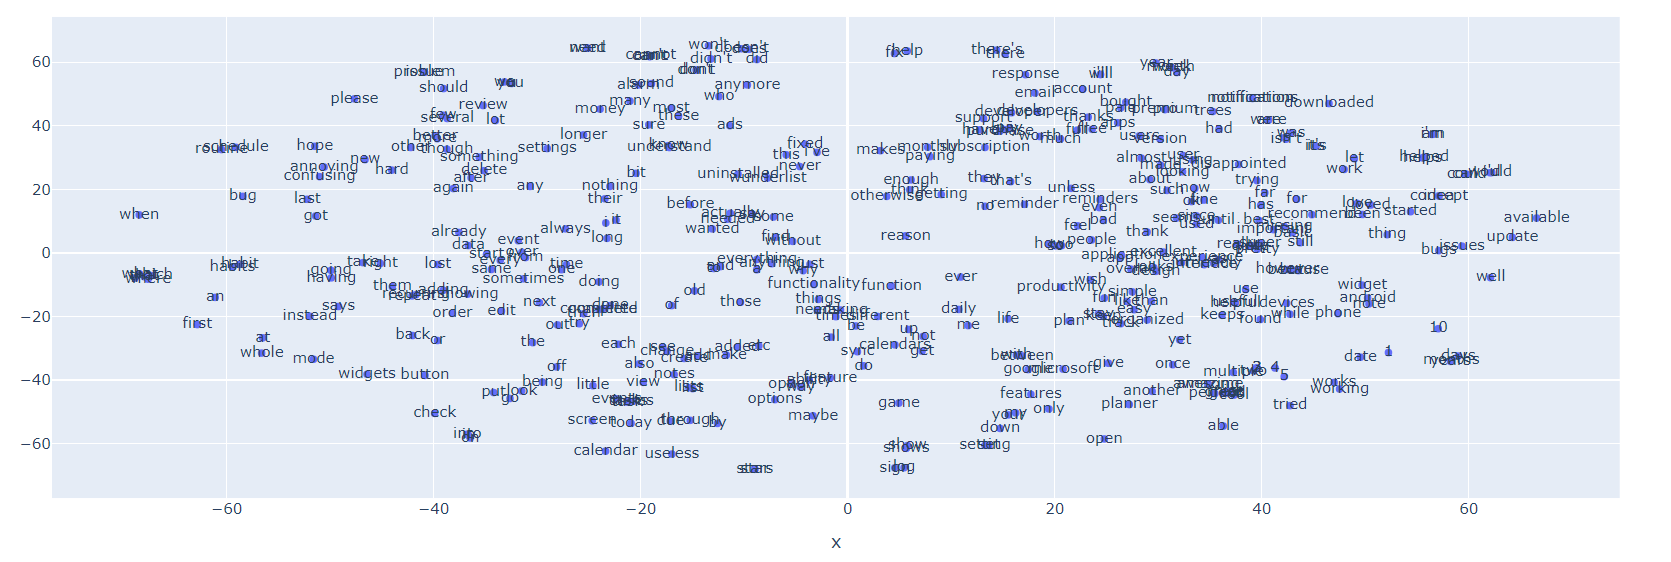